In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools
import multiprocessing
from joblib import Parallel, delayed, pool
#from joblib.pool import has_shareable_memory

## change in velocity
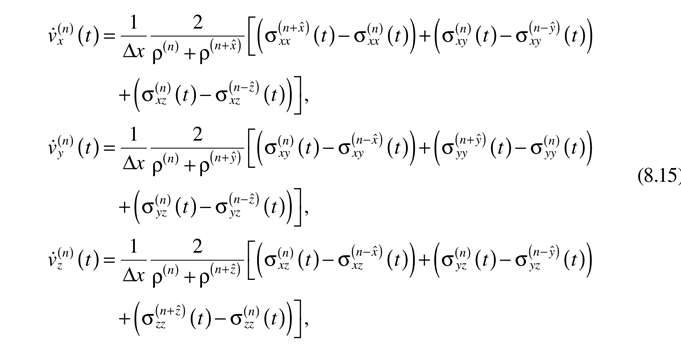

## change in stress
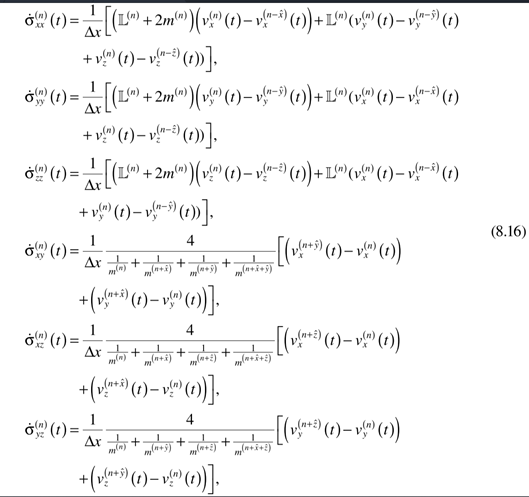

## update rules
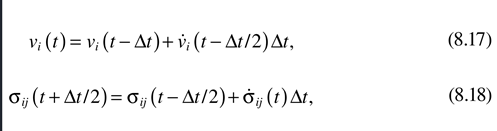

## Boundary Conditions
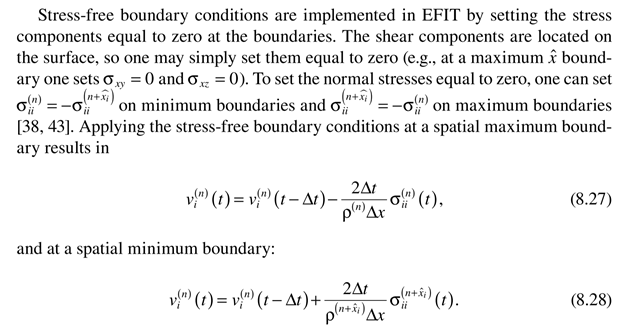

## Stability Conditions
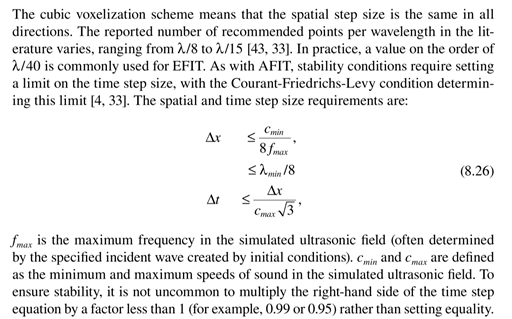

## General Procedure 

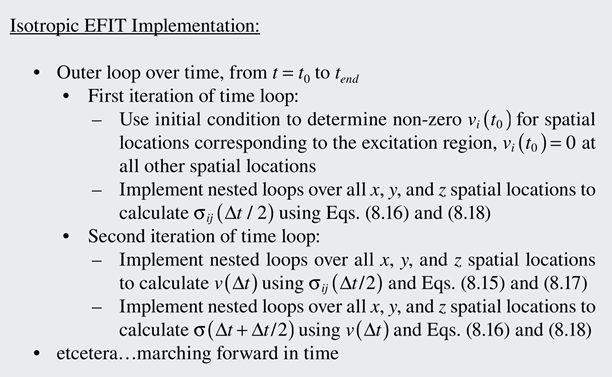

In [2]:
# set Constants

#MATERIAL 1 ((iron))
pRatio1 = 0.30                                     #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter


#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

print('material 1 wave speeds:' ,cl1,ct1)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency




#MATERIAL 2  (concrete)
pRatio2= 0.15
yModulus2= 24*(10**9)
rho2 = 2400       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = 2 * mu2 * pRatio2 / (1 - 2 * pRatio2)     

#Calculate speed of longitudinal and transverse waves in material 1
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

print('material 2 wave speeds:' ,cl2,ct2)

#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency


#dimensions of materials in meters
#the dimensions of material 1 should be greater than material 2
#diensions of material 1 

length1 = 0.20
width1 = 0.20
height1 = 0.10

#dimensions for material 2

length2= 0.1
width2= 0.1
height2= 0.15



material 1 wave speeds: 5875.097044815179 3140.3714651066384
material 2 wave speeds: 3249.462449572256 2085.144140570748


In [3]:
#Run for 6 Cycles:
runtime = 7.5 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1,omegaL2,omegaT2) /12)    #grid step
ts = gs/((max(cl1,ct1,cl2,ct2))*(np.sqrt(3)))*0.8732 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) *2       #length 
gw1 = int(math.ceil(width1 / gs)) *2        #width
gh1 = int(math.ceil(height1 / gs)) *2       #height


#print(runtime, ts, gs, Tsteps, gl, gh)

print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
print('grid step size, # of length pts, # of height pts, # of width pts:', gs, gl1, gw1,gh1)


runtime (s), time step size (s), total # of time steps: 0.0001875 3.727630869776573e-07 505
grid step size, # of length pts, # of height pts, # of width pts: 0.004344050292855724 94 94 48


In [4]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

matProps=np.zeros((3,gl1,gw1,gh1))
matProps[0,:,:,:]=rho1
matProps[1,:,:,:]=lmbda1
matProps[2,:,:,:]=mu1

#defining where the 2nd material lies in the grid
#for now we'll simulate a square rod of material 2 in the middle of a block 
#made up of material 1

gl2 = int(math.ceil(length2 / gs))       
gw2 = int(math.ceil(width2 / gs))         
gh2 = int(math.ceil(height2 / gs))

for x in range(gl1):
    for y in range(gw1):
        if x < y:
            matProps[0,x,y,:]=rho2
            matProps[1,x,y,:]=lmbda2
            matProps[2,x,y,:]=mu2

print('Total # of grid pts, # of material 1 pts, # of material 2 pts:', [gl1*gw1*gh1, gl1*gw1*gh1-8*gl2*gw2*gh2, 8*gl2*gw2*gh2])
print('material 2 indices:')
print('x:',[int(gl1/2)-gl2, int(gl1/2)+gl2])
print('y:',[int(gw1/2)-gw2, int(gw1/2)+gw2])
print('z:', [0, gh2*2])

Total # of grid pts, # of material 1 pts, # of material 2 pts: [424128, 262848, 161280]
material 2 indices:
x: [23, 71]
y: [23, 71]
z: [0, 70]


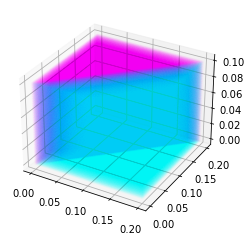

In [5]:
#3D scatter plot of grid pts to show geometry 
#of the 2 materials

x=np.linspace(0,length1,gl1)
y=np.linspace(0,width1,gw1)
z=np.linspace(0,height1,gh1)

X, Y, Z = np.meshgrid(x, y, z)

U=matProps[0,:,:,:]

plt.figure()


ax=plt.axes(projection='3d')

fig=ax.scatter3D(X,Y,Z,c=U, alpha=0.02, marker='.', cmap='cool')

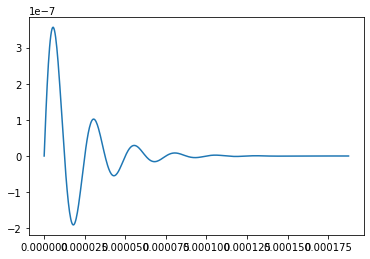

In [6]:
#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 50000
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)

plt.plot(timeVec,sinInputSignal)

plt.ioff()

In [7]:
#boundary values 
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

#initialize fields
vx=np.zeros((gl1,gw1,gh1))
vy=np.zeros((gl1,gw1,gh1))
vz=np.zeros((gl1,gw1,gh1))

sxx=np.zeros((gl1,gw1,gh1))
syy=np.zeros((gl1,gw1,gh1))
szz=np.zeros((gl1,gw1,gh1))
sxy=np.zeros((gl1,gw1,gh1))
sxz=np.zeros((gl1,gw1,gh1))
syz=np.zeros((gl1,gw1,gh1))

#record the signal at a specified location
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vx1Signal=np.zeros(Tsteps)
vy1Signal=np.zeros(Tsteps)
vz1Signal=np.zeros(Tsteps)

vx2Signal=np.zeros(Tsteps)
vy2Signal=np.zeros(Tsteps)
vz2Signal=np.zeros(Tsteps)


In [8]:
def updateStresses(x,y,z):
    
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps[1,x,y,z]+2*matProps[2,x,y,z])
    norm2=(1/gs)*(matProps[1,x,y,z])

    shearDenomxy=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x+1,y+1,z])
    shearxy=4*(1/gs)*(1/shearDenomxy)

    shearDenomxz=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x+1,y,z+1])
    shearxz=4*(1/gs)*(1/shearDenomxz)

    shearDenomyz=(1/matProps[2,x,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x,y+1,z+1])
    shearyz=4*(1/gs)*(1/shearDenomyz)

    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
    sxx[x,y,z]=sxx[x,y,z]+ds*ts

    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
    syy[x,y,z]=syy[x,y,z]+ds*ts

    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
    szz[x,y,z]=szz[x,y,z]+ds*ts

    ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
    sxy[x,y,z]=sxy[x,y,z]+ds*ts

    ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
    sxz[x,y,z]=sxz[x,y,z]+ds*ts   

    ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
    syz[x,y,z]=syz[x,y,z]+ds*ts

    #delete variables for updates
    del norm1, norm2


In [9]:
def updateStressBoundary(x,y,z):
        
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps[1,x,y,z]+2*matProps[2,x,y,z])
    norm2=(1/gs)*(matProps[1,x,y,z])


    if x!=0 and x!=xmax and y!=0 and y!=ymax:
        shearDenomxy=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x+1,y+1,z])
        shearxy=4*(1/gs)*(1/shearDenomxy)

    if x!=0 and x!=xmax and z!=0 and z!=zmax:

        shearDenomxz=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x+1,y,z+1])
        shearxz=4*(1/gs)*(1/shearDenomxz)

    if y!=0 and y!=ymax and z!=0 and z!=zmax:

        shearDenomyz=(1/matProps[2,x,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x,y+1,z+1])
        shearyz=4*(1/gs)*(1/shearDenomyz)

    #FACES
    if x!=0 and x!=xmax and y!=0 and y!=ymax and z==0:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z+1]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        sxy[x,y,z]=sxy[x,y,z]+ds*ts
        del shearxy

        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==0 and y!=0 and y!=ymax and z!=0 and z!=zmax:


        sxx[x,y,x]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        syz[x,y,z]=syz[x,y,z]+ds*ts
        del shearyz

    elif x==xmax and y!=0 and y!=ymax and z!=0 and z!=zmax:
        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        syz[x,y,z]=syz[x,y,z]+ds*ts
        del shearyz

    elif x!=0 and x!=xmax and y==0 and z!=0 and z!=zmax:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        sxz[x,y,z]=sxz[x,y,z]+ds*ts
        del shearxz

        syz[x,y,z]=0

    elif x!=0 and x!=xmax and y==ymax and z!=0 and z!=zmax:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        sxz[x,y,z]=sxz[x,y,z]+ds*ts
        del shearxz

        syz[x,y,z]=0

    elif x!=0 and x!=xmax and y!=0 and y!=ymax and z==zmax:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        sxy[x,y,z]=sxy[x,y,z]+ds*ts
        del shearxy

        sxz[x,y,z]=0
        syz[x,y,z]=0


    #EDGES
    #bottom edges
    elif x==0 and y!=0 and y!=ymax and z==0:

        sxx[x,y,z]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==xmax and y!=0 and y!=ymax and z==0:

        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif x!=0 and x!=xmax and y==0 and z==0:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif x!=0 and x!=xmax and y==ymax and z==0:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    #side edges
    elif x==0 and y==0 and z!=0 and z!=zmax:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif x==xmax and y==0 and z!=0 and z!=zmax:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==0 and y==ymax and z!=0 and z!=zmax:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif x==xmax and y==ymax and z!=0 and z!=zmax:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    #top edges
    elif x==0 and y!=0 and y!=ymax and z==zmax:

        sxx[x,y,z]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==xmax and y!=0 and y!=ymax and z==zmax:

        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x!=0 and x!=xmax and y==0 and z==zmax:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif x!=0 and x!=xmax and y==ymax and z==zmax:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    #CORNERS

    elif x==0 and y==0 and z==0:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==0 and y==0 and z==zmax:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==0 and y==ymax and z==0:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==0 and y==ymax and z==zmax:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==xmax and y==0 and z==0:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==xmax and y==0 and z==zmax:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==xmax and y==ymax and z==0:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif x==xmax and y==ymax and z==zmax:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


In [10]:
def updateVelocity(x,y,z):
    #calculate constants for velocity
    if x!=xmax:
        dvxConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x+1,y,z]))
        vminx=(2*ts)/(matProps[0,x+1,y,z]*gs)

    if y!=ymax:
        dvyConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y+1,z]))
        vminy=(2*ts)/(matProps[0,x,y+1,z]*gs)

    if z!=zmax:
        dvzConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y,z+1]))
        vminz=(2*ts)/(matProps[0,x,y,z+1]*gs)


    vmax=(2*ts)/(matProps[0,x,y,z]*gs)


    dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
    vx[x,y,z]=vx[x,y,z]+dv*ts

    dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
    vy[x,y,z]=vy[x,y,z]+dv*ts

    dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
    vz[x,y,z]=vz[x,y,z]+dv*ts

    del dvxConst, dvyConst, dvzConst


In [11]:
def updateVelocityBoundary(x,y,z):
    if x!=xmax:
        dvxConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x+1,y,z]))
        vminx=(2*ts)/(matProps[0,x+1,y,z]*gs)

    if y!=ymax:
        dvyConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y+1,z]))
        vminy=(2*ts)/(matProps[0,x,y+1,z]*gs)

    if z!=zmax:
        dvzConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y,z+1]))
        vminz=(2*ts)/(matProps[0,x,y,z+1]*gs)
    
    vmax=(2*ts)/(matProps[0,x,y,z]*gs)

    #FACES
    if x!=0 and x!=xmax and y!=0 and y!=ymax and z==0:
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]


    elif x==0 and y!=0 and y!=ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif x==xmax and y!=0 and y!=ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif x!=0 and x!=xmax and y==0 and z!=0 and z!=zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif x!=0 and x!=xmax and y==ymax and z!=0 and z!=zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts                     


    elif x!=0 and x!=xmax and y!=0 and y!=ymax and z==zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts


        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]



    #EDGES
    #bottom edges
    elif x==0 and y!=0 and y!=ymax and z==0:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==xmax and y!=0 and y!=ymax and z==0:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x!=0 and x!=xmax and y==0 and z==0:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x!=0 and x!=xmax and y==ymax and z==0:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    #side edges
    elif x==0 and y==0 and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif x==xmax and y==0 and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif x==0 and y==ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts



    elif x==xmax and y==ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    #top edges
    elif x==0 and y!=0 and y!=ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif x==xmax and y!=0 and y!=ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x!=0 and x!=xmax and y==0 and z==zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif x!=0 and x!=xmax and y==ymax and z==zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    #CORNERS
    elif x==0 and y==0 and z==0:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==0 and y==0 and z==zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x==0 and y==ymax and z==0:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==0 and y==ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x==xmax and y==0 and z==0:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==xmax and y==0 and z==zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x==xmax and y==ymax and z==0:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==xmax and y==ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]




In [12]:
Points = []
for x in range(gl1-2):
    for y in range(gw1-2):
        for z in range(gh1-2):
            Points.append([x+1,y+1,z+1])


BoundaryPoints=[]
for x in [0,gl1-1]:
    for y in range(gw1-2):
        for z in range(gh1-2):
            BoundaryPoints.append([x,y+1,z+1])
for x in range(gl1-2):
    for y in [0,gw1-1]:
        for z in range(gh1-2):
            BoundaryPoints.append([x+1,y,z+1])
for x in range(gl1-2):
    for y in range(gw1-2):
        for z in [0,gh1-1]:
            BoundaryPoints.append([x+1,y+1,z])
for x in [0,gl1-1]:
    for y in [0,gw1-1]:
        for z in range(gh1-2):
            BoundaryPoints.append([x,y,z+1])
for x in [0,gl1-1]:
    for y in range(gw1-2):
        for z in [0,gh1-1]:
            BoundaryPoints.append([x,y+1,z])
for x in range(gl1-2):
    for y in [0,gw1-1]:
        for z in [0,gh1-1]:
            BoundaryPoints.append([x+1,y,z])
for x in [0,gl1-1]:
    for y in [0,gw1-1]:
        for z in [0,gh1-1]:
            BoundaryPoints.append([x,y,z])

In [13]:
print(np.shape(Points)[0] + np.shape(BoundaryPoints)[0], gl1, gw1, gh1, (gl1-1)*(gw1-1)*(gh1-1))


424128 94 94 48 406503


In [14]:
stime = time.time()
jobs = 15

for t in range(0,Tsteps):
    
       
    #sin-exponential input
    vz[inputx,inputy,inputz]=vz[inputx,inputy,inputz]-szzConst*szz[inputx,inputy,inputz]+sinInputSignal[t]
    
    
    #update Stresses
    #Parallel(n_jobs=jobs,prefer="threads")(delayed(updateStresses)(i[0],i[1],i[2]) for i in Points)
    for i in Points: updateStresses(i[0],i[1],i[2])
    for i in BoundaryPoints: updateStressBoundary(i[0],i[1],i[2])
    #removed: , require='sharedmem', verbose = 0,prefer="threads")
    #for x in range(gl1):
    #    for y in range(gw1):
    #        for z in range(gh1):
    #            #updateStresses(x,y,z)
 
    #for i in Points:            
    #    updateStresses(i[0],i[1],i[2])
                
    
    #update Velocities
    #Parallel(n_jobs=jobs,prefer="threads")(delayed(updateVelocity)(i[0],i[1],i[2]) for i in Points)
    for i in Points: updateVelocity(i[0],i[1],i[2])
    for i in BoundaryPoints: updateVelocityBoundary(i[0],i[1],i[2])
    #removed: , require='sharedmem', verbose = 0,prefer="threads")
    #for x in range(gl1):
    #    for y in range(gw1):
    #        for z in range(gh1):
    #            #updateVelocity(x,y,z)
   
    #for i in Points:
    #    updateVelocity(i[0],i[1],i[2])
        
    
    #record signals
    vx1Signal[t]=vx[int(signalLocx/2),signalLocy,signalLocz]
    vy1Signal[t]=vy[int(signalLocx/2),signalLocy,signalLocz]
    vz1Signal[t]=vz[int(signalLocx/2),signalLocy,signalLocz]
    
    vx2Signal[t]=vx[int(3*signalLocx/2),signalLocy,signalLocz]
    vy2Signal[t]=vy[int(3*signalLocx/2),signalLocy,signalLocz]
    vz2Signal[t]=vz[int(3*signalLocx/2),signalLocy,signalLocz]
    
    #save vx cut figure
    if t%10==0:
        fig=plt.figure()
        plt.contourf(np.transpose(vz[:,:,int(gh1/2)]), cmap='seismic')
        plt.savefig('images/vzmidCut'+str(t)+'.png')
        plt.close(fig)
    
    
    print(t,'/',Tsteps-1,'checksums vx, sxx:',np.sum(np.absolute(vx)),np.sum(np.absolute(sxx)), time.time()-stime)

0 / 504 checksums vx, sxx: 0.0 0.0 12.163328409194946
1 / 504 checksums vx, sxx: 8.01212574154122e-09 0.033613381314682216 24.22603440284729
2 / 504 checksums vx, sxx: 3.605564765233446e-08 0.1260912241783088 36.172280073165894
3 / 504 checksums vx, sxx: 9.430881564101436e-08 0.28822469204250906 48.12237763404846
4 / 504 checksums vx, sxx: 1.8607110470054782e-07 0.5122025748707614 60.07702922821045
5 / 504 checksums vx, sxx: 3.05697229377357e-07 0.7836562192207766 72.01198196411133
6 / 504 checksums vx, sxx: 4.40183371473619e-07 1.4807016936376785 83.92391753196716
7 / 504 checksums vx, sxx: 5.734000227500757e-07 2.516310710003885 95.87057113647461
8 / 504 checksums vx, sxx: 6.909090886042737e-07 3.6185379473769577 107.82580256462097
9 / 504 checksums vx, sxx: 8.085212993794539e-07 4.688631500605377 119.76197934150696
10 / 504 checksums vx, sxx: 9.122922124552196e-07 5.680522657183804 131.76945686340332
11 / 504 checksums vx, sxx: 9.990949291224624e-07 6.618467758882853 143.74834823608

95 / 504 checksums vx, sxx: 2.5243832077230287e-05 159.44588207090732 1147.8271837234497
96 / 504 checksums vx, sxx: 2.571671875278673e-05 163.42665671767418 1159.7654271125793
97 / 504 checksums vx, sxx: 2.6242627732064216e-05 167.4084902305281 1171.7105298042297
98 / 504 checksums vx, sxx: 2.673894166927432e-05 171.40541329374992 1183.633586883545
99 / 504 checksums vx, sxx: 2.722868104731851e-05 175.2958835867956 1195.5694890022278
100 / 504 checksums vx, sxx: 2.7716680338223787e-05 179.15501895083162 1207.5654602050781
101 / 504 checksums vx, sxx: 2.817899882987285e-05 182.75798943672837 1219.507673740387
102 / 504 checksums vx, sxx: 2.863175382657565e-05 186.32351567908466 1231.4394087791443
103 / 504 checksums vx, sxx: 2.9129582716119747e-05 190.00960748956302 1243.3721573352814
104 / 504 checksums vx, sxx: 2.9569353725211808e-05 193.61319571048847 1255.292268037796
105 / 504 checksums vx, sxx: 3.0028941726399588e-05 197.04376655186528 1267.2171881198883
106 / 504 checksums vx, s

188 / 504 checksums vx, sxx: 5.663877268092766e-05 514.0517280185928 2260.998478412628
189 / 504 checksums vx, sxx: 5.694807829792456e-05 521.897552677658 2272.9833784103394
190 / 504 checksums vx, sxx: 5.727250145638356e-05 529.5938997826332 2284.995391368866
191 / 504 checksums vx, sxx: 5.761532696643137e-05 537.1889333141489 2296.9341735839844
192 / 504 checksums vx, sxx: 5.7991384618205775e-05 544.8713030583142 2308.866377592087
193 / 504 checksums vx, sxx: 5.8396028688013e-05 552.9259296198115 2320.7910730838776
194 / 504 checksums vx, sxx: 5.880977204090509e-05 561.3137697875142 2332.701959133148
195 / 504 checksums vx, sxx: 5.928704548583712e-05 570.0569180418627 2344.640507221222
196 / 504 checksums vx, sxx: 5.9819743608192245e-05 579.1027806999311 2356.5810871124268
197 / 504 checksums vx, sxx: 6.0365461105603795e-05 588.1043486616602 2368.4776237010956
198 / 504 checksums vx, sxx: 6.095929330251236e-05 597.3448370048565 2380.4174304008484
199 / 504 checksums vx, sxx: 6.156035

282 / 504 checksums vx, sxx: 0.0001179230459379655 1936.9675104656737 3385.2703227996826
283 / 504 checksums vx, sxx: 0.00011894276091266462 1958.6504111756692 3397.1956419944763
284 / 504 checksums vx, sxx: 0.00012002039170016248 1980.4222703831547 3409.2700350284576
285 / 504 checksums vx, sxx: 0.00012110933485843736 2001.5881835650735 3421.1748542785645
286 / 504 checksums vx, sxx: 0.00012221962976402697 2022.801628000926 3433.077917098999
287 / 504 checksums vx, sxx: 0.00012332026095401323 2044.1624705655722 3445.0309109687805
288 / 504 checksums vx, sxx: 0.00012439345643966562 2065.829813169264 3456.957041501999
289 / 504 checksums vx, sxx: 0.0001254507297746776 2088.264455477398 3468.9021587371826
290 / 504 checksums vx, sxx: 0.00012646830731832608 2112.209964167639 3480.882205247879
291 / 504 checksums vx, sxx: 0.00012744159425309804 2137.747254062912 3492.793220758438
292 / 504 checksums vx, sxx: 0.00012836593480821228 2164.3821742594405 3504.723100423813
293 / 504 checksums vx

375 / 504 checksums vx, sxx: 0.00025312881830661017 7387.750507106416 4494.814688920975
376 / 504 checksums vx, sxx: 0.0002552966522292025 7512.527543188042 4506.7297995090485
377 / 504 checksums vx, sxx: 0.0002575006006966422 7650.908654906524 4518.675272464752
378 / 504 checksums vx, sxx: 0.00025991345311645887 7795.909356275764 4530.572173833847
379 / 504 checksums vx, sxx: 0.00026251282843993634 7942.354020473185 4542.498193502426
380 / 504 checksums vx, sxx: 0.00026523508835836804 8080.226340522125 4554.5160348415375
381 / 504 checksums vx, sxx: 0.00026798370698696936 8228.402126313302 4566.459922790527
382 / 504 checksums vx, sxx: 0.0002707372181089763 8392.921615494257 4578.437119483948
383 / 504 checksums vx, sxx: 0.00027372400974437304 8564.877107311702 4590.474309682846
384 / 504 checksums vx, sxx: 0.00027683812795720354 8736.597799138177 4602.55442070961
385 / 504 checksums vx, sxx: 0.00028031103640963507 8898.195020861587 4614.802850484848
386 / 504 checksums vx, sxx: 0.000

469 / 504 checksums vx, sxx: 0.0019677495701329144 61464.4970717289 5618.711664438248
470 / 504 checksums vx, sxx: 0.0020367700766230797 63205.47456794622 5630.733857870102
471 / 504 checksums vx, sxx: 0.002108333614455288 65253.6121448676 5642.63253736496
472 / 504 checksums vx, sxx: 0.002184343349158622 67528.90881842548 5654.557299852371
473 / 504 checksums vx, sxx: 0.0022682579974360843 69642.8573595295 5666.498558282852
474 / 504 checksums vx, sxx: 0.002357263537211916 71518.41503908604 5678.436975717545
475 / 504 checksums vx, sxx: 0.002447831913267479 73451.08819892287 5690.362828731537
476 / 504 checksums vx, sxx: 0.002536746230670945 75884.92590612965 5702.278626203537
477 / 504 checksums vx, sxx: 0.002628789213119137 78658.95141530447 5714.19757938385
478 / 504 checksums vx, sxx: 0.0027314737458236623 81451.99030769322 5726.140198230743
479 / 504 checksums vx, sxx: 0.0028466704798566114 83910.43269860846 5738.074647665024
480 / 504 checksums vx, sxx: 0.0029675948355696573 861

3 loops and functions
0 / 463 checksums vx, sxx: 0.0 0.0 42.54019045829773
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 85.9329047203064
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 129.34246444702148
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 172.73137998580933
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 216.12839102745056

1 loop and functions
0 / 463 checksums vx, sxx: 0.0 0.0 43.41779279708862
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 87.03242444992065
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 130.67627906799316
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 174.14996218681335
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 217.67327785491943

code in series
0 / 463 checksums vx, sxx: 0.0 0.0 49.54623055458069
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 98.71403884887695
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 148.13409042358398
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 197.24465084075928
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 246.56837677955627

10 parallel tasks sharing variables shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 263.45540499687195
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 517.9381580352783

1 parallel task sharing variables shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 973.7282524108887
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 1892.5281636714935

20 parallel task shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 203.8962342739105220 
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 410.43651604652405

30 parallel shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 434.80657958984375
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 873.0215351581573
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 1293.599306344986
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 1773.760350227356
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 2213.5885384082794

10 parallel no share
0 / 463 checksums vx, sxx: 0.0 0.0 273.3588342666626
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 524.6249568462372
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 776.7317447662354
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 1084.5888712406158

20 parallel no share
0 / 463 checksums vx, sxx: 0.0 0.0 216.18960332870483
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 442.9726667404175
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 636.7484667301178


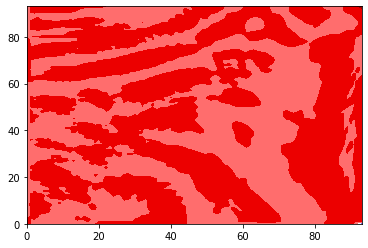

In [15]:
plt.contourf(np.transpose(vz[:,:,15]), cmap='seismic')

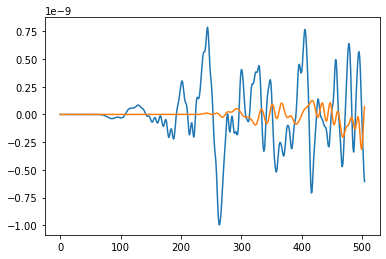

In [16]:
plt.plot(vx1Signal)
plt.plot(vx2Signal)
plt.show()

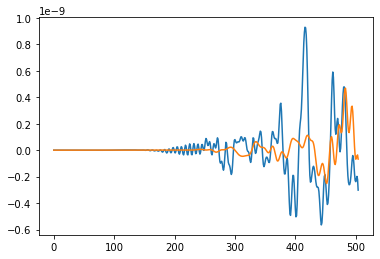

In [17]:
plt.plot(vy1Signal)
plt.plot(vy2Signal)
plt.show()

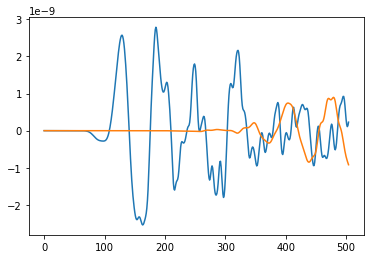

In [18]:
plt.plot(vz1Signal)
plt.plot(vz2Signal)
plt.show()

In [19]:
# make animated gif from saved EFIT figures

import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}/efitAnim.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0)
    

In [20]:
frame_folder='/sciclone/home20/dchendrickson01/Code/3D_EFIT/OtherCode/images'

frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]

In [21]:
frame_one = frames[0]
frame_one.save(f"{frame_folder}/efitAnim.gif", format="GIF", append_images=frames,
           save_all=True, duration=300, loop=0)

In [22]:
cl1/cl2

1.8080212145822918

In [23]:
ct1/ct2

1.5060692467270165